# BYOL: Bring You Own Loss Function

This notebook contains the code for the Medium post `BYOL: Bring You Own Loss Function` about potential benefits from customization of a loss function and its parctical application in Gradient Boosting model

Additionally, consider installing this library, that implements the functionality of both of the custom loss functions
https://github.com/pashna/gbm_custom_loss


*This code takes some time to run, especially HPO our the custom loss functions. 
Not, for sake of the speed, I will run only a few HPO rounds, but the reader can comment next row (MAX_EVAL should be 120, SAMPLE_FEATURES should be False) in order to restore the number that I was stating in the medium post.*


In [1]:
MAX_EVAL = 3
SAMPLE_FEATURES = True

In [2]:
from matplotlib import rc
rc('animation', html='jshtml')
from matplotlib import pyplot as plt
class PiecewiseObjective(object):
    
    def __init__(self, intervals_values, name="Piecewise"):
        self.intervals_values = intervals_values
        self.name = name
        super().__init__()
    
    def __str__(self):
        interval_list = []
        for interval, params in self.intervals_values.items():
            value = ""
            for k, v in params.items():
                value += "{}={}|".format(k,v)
            value = value[:-1]
            interval_list.append([interval[0], interval[1], value])

        weight_list = sorted(interval_list, key=lambda s: s[0])
        weight_list_str = "\n".join(["({}, {}) -> {}".format(*w) for w in weight_list])
        return self.name + ":\n" + weight_list_str
    
    def __repr__(self):
        return self.__str__()
    
    def _find_params(self, diff, params=["coef"]):
        for lower_bound, upper_bound in self.intervals_values.keys():
            if (diff > lower_bound) and (diff <= upper_bound):
                retrieved_values = []
                return [self.intervals_values[(lower_bound, upper_bound)][p] for p in params]
        return [1]

In [3]:
!mkdir gif

mkdir: cannot create directory ‘gif’: File exists


In [4]:
!pip install catboost

In [5]:
!apt install imagemagick
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


# Let's first define objective. 

In our case, objective is expected average ranking (negative), which we want to minimize. It is predifined based on the previous orders performance: for example, if the order was 2-5 minutes late, average rating over last 2 months was 4.95.

We segment all the orders to obtain significant difference in rating based on delivery time estimation error. 

Beauty of the objective is that it can be as complex as your business wants. For example, you can even integrate another churn prediction model and make it function not only of the error, but of any order (object) related features. The only limitation, your objective must depend on your target.

In [6]:
import numpy as np

class RatingObjective(PiecewiseObjective):
    """
    Class defines objective function according to CatBoost API
    https://catboost.ai/docs/concepts/python-usages-examples.html#custom-loss-function-eval-metric
    
    The interpretation of this objective is the (negative) average expected rating 
    for the deliveries
    (lower_bound, upper_bound, mse_coefficient)
    
    So, the value of objective is defined by:
        objective_i = rating(y_true - y_pred)
        
        where rating(diff): score given diff in (lower_bound, upper_bound]
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = "RatingObjective"

    def get_final_error(self, error, weight):
        return error / 1

    def is_max_optimal(self):
        return False

    def evaluate(self, approx, target, weight=None):
        if not weight:
            weight = np.ones_like(target)
        error_sum = 0.0
        approx = approx[0] 
        
        for i in range(len(approx)):
            error = target[i] - approx[i]
            coef = self._find_params(error, ["coef"])[0]
            error_sum += coef * weight[i]
                
        return -error_sum/np.sum(weight), np.sum(weight)

In [7]:
rating_obj = RatingObjective(intervals_values={(-1e20, 5): {"coef": 4.9}, 
                                               (5, 15):  {"coef": 4.2},
                                               (15, 1e20):  {"coef": 4}})
print(rating_obj)
rating_obj.evaluate([np.linspace(-30, 30, 90)], np.zeros(90))[0]

RatingObjective:
(-1e+20, 5) -> coef=4.9
(5, 15) -> coef=4.2
(15, 1e+20) -> coef=4


-4.553333333333326

In [8]:
import numpy as np

class RMSEObjective(object):
    def get_final_error(self, error, weight):
        return error / 1

    def is_max_optimal(self):
        return False

    def evaluate(self, approx, target, weight=None):
        if not weight:
            weight = np.ones_like(target)
        error_sum = 0.0
        approx = approx[0] 
        
        for i in range(len(approx)):
            error = (target[i] - approx[i]) ** 2
            error_sum += error * weight[i]
                
        return np.sqrt(error_sum/np.sum(weight)), np.sum(weight)

# Now, let's define Loss Function

The function, in contrast to objective function, has to be differentiable. Here, I am just choosing a slightly customized MSE: now, it will have additional predifined scaling factors, that would depend on the error: y_true_i - y_pred_i. By changing these factors, we will enforce level of importance for each of the object (order) at every gradient boosting training iteration. 

It is also can be seen as a combination of dynamic weights with MSE loss.

In [9]:
from math import sqrt
class PiecewiseMSE(PiecewiseObjective):
    """
    Class defines loss function according to CatBoost API
    https://catboost.ai/docs/concepts/python-usages-examples.html#user-defined-loss-function

    Interpretation of the loss: if the error for the object falls within predefined interval,
    we take it squared error and multiply by a corresponding to this error coefficient.

    The loss function is defined by mse_pieces:
      (lower_bound, upper_bound, coef)

    So, the value of loss function is defined by:
        loss_i = coef_k*(y_true_i - y_pred_i)^2

        where coef_k: coef_k(y_true_i - y_pred_i) - step functions of residual,
                                                    defined in the configuration
    """
    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)
        self.name = "PiecewiseMSE"
    
    def _validate_input(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
    
    def calc_ders_range(self, approxes, targets, weights):
        """
        Returns a list of tuples with first and second derivitave
        """
        self._validate_input(approxes, targets, weights)
        result = []
        for index in range(len(targets)):
            diff = targets[index] - approxes[index]
            coef = self._find_params(diff, ["coef"])[0]
            
            der1, der2 = diff*coef, -coef

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            result.append((der1, der2))
        return result
    
    def evaluate(self, approx, target, weight=None):

        loss = 0.0
        approx = approx[0]
        weight = np.ones_like(target) if weight is None else weight

        for i in range(len(approx)):
            diff = (target[i] - approx[i])
            coef = self._find_params(diff, ["coef"])[0]
            loss += weight[i] * coef * (diff**2)

        return loss/np.sum(weight), np.sum(weight)

In [10]:
pwmse = PiecewiseMSE(intervals_values={ 
                                         (-1e20, 5): {"coef": 10}, 
                                         (5, 1e20): {"coef": 100}
                                        })
print(pwmse)
pwmse.evaluate([np.linspace(-30, 30, 90)], np.zeros(90))[0]

PiecewiseMSE:
(-1e+20, 5) -> coef=10
(5, 1e+20) -> coef=100


16819.08849892689

# Biased Piecewise MSE objective

In [11]:
from math import sqrt
class BiasedPiecewiseMSE(PiecewiseMSE):
    """
    Class defines loss function according to CatBoost API
    https://catboost.ai/docs/concepts/python-usages-examples.html#user-defined-loss-function

    Interpretation of the loss: if the error for the object falls within predefined interval,
    we take it squared error and multiply by a corresponding the this error coefficient and shift
    with a corresponding bias.

    The loss function is defined by mse_pieces:
    (lower_bound, upper_bound, coef, bias)
    
    So, the value of loss function is defined by:
        loss_i = coef_k(y_true_i - y_pred_i - bias_k)^2
    
    So, the value of loss function is defined by:
        loss_i = coef_k*(y_true_i - y_pred_i - bias_k)^2

        where coef_k: coef_k(y_true_i - y_pred_i),
              bias_k: bias_k(y_true_i - y_pred_i)
                - step functions of residual
    """
    def __init__(self, *args, **kwargs):
        """
        :param intervals_values: dict, where key is a tuple that represents a left-open,
                                        right-closed interval.
                                        The value of the dict is a another dictionary where
                                        each item each has a parameter name as a key and the value is a number.
                                        For Piecewise MSE, the nested key is required to be "coef".
                                        Example:
                                        {
                                          (-1e20, 5): {"coef": 10, 
                                                      "bias": 0.1},
                                          (5, 1e20): {"coef": 100,
                                                      "bias": -24}
                                        }
        :param kwargs:
        """
        super().__init__(*args, **kwargs)
        self.name = "BiasedPiecewiseMSE"

    def calc_ders_range(self, approxes, targets, weights):
        """
        Returns a list of tuples with first and second derivitave
        """
        self._validate_input(approxes, targets, weights)
        result = []
        for index in range(len(targets)):
            diff = targets[index] - approxes[index]
            coef, bias = self._find_params(diff, ["coef", "bias"])
            
            der1, der2 = (diff-bias)*coef, -coef

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]
            result.append((der1, der2))
        return result
    
    def evaluate(self, approx, target, weight=None):

        loss = 0.0
        approx = approx[0]
        weight = np.ones_like(target) if weight is None else weight

        for i in range(len(approx)):
            diff = (target[i] - approx[i])
            coef, bias = self._find_params(diff, ["coef", "bias"])
            loss += weight[i] * coef * ((target[i] - approx[i] - bias)**2)

        return loss/np.sum(weight), np.sum(weight)

In [12]:
pwmse = BiasedPiecewiseMSE(intervals_values={ 
                                         (-1e20, 5): {"coef": 10,
                                                      "bias": 0}, 
                                         (5, 1e20): {"coef": 100,
                                                     "bias": 0},
                                        })
print(pwmse)
pwmse.evaluate([np.linspace(-30, 30, 90)], np.zeros(90))[0]

BiasedPiecewiseMSE:
(-1e+20, 5) -> coef=10|bias=0
(5, 1e+20) -> coef=100|bias=0


16819.08849892689

# Also, we need a few helpers to make it all work smooth 

#### Some helpers to visualize loss function 

In [13]:
def calculate_mse(approx, target, weight=None):
    loss = 0.0
    weight = np.ones_like(target) if weight is None else weight
    for i in range(len(approx)):
        error = (target[i] - approx[i])
        loss += weight[i] * error * error

    return loss/len(approx), weight

def calculate_quantile(approx, target, alpha=0.5, weight=None):
    loss = 0.0
    
    weight = np.ones_like(target) if weight is None else weight
    for i in range(len(approx)):
        mult = 1 if target[i] <= approx[i] else 0
        loss += (alpha - mult)*(target[i] - approx[i])*weight[i]

    return loss/len(approx), weight

def calculate_rmse(approx, target, weight=None):
    loss, weight = calculate_mse(approx, target, weight)
    return sqrt(loss/len(approx)), weight

def plot_loss(objective, values_range=(-40, 40)):
    if type(objective) == str:
        if objective.lower() == 'rmse':
            calc_obj = calculate_mse
        elif 'quantile' in objective.lower():
            alpha = float(objective.split('=')[1])
            calc_obj = lambda approx, target: calculate_quantile(approx, target, alpha=alpha, weight=None)
        else:
            raise Exception("Objective {} is not supported".format(objective))
    else:
        calc_obj = objective.evaluate
        
    space = np.linspace(values_range[0], values_range[1], 5*abs(int(values_range[1]-values_range[0])))
    
    objective_values = []
    for s in space:
        objective_values.append(calc_obj([[0]], [s])[0])
    
    return space, objective_values

#### And some functions to standartisize dataset loading 
and make it easier for everyone to replicate the work with their own data

In [14]:
import pandas as pd


class DatasetLoader:

    def get_cat_features_idx(self):
        return self._cat_features_idx
    
    def get_train_test(self):
        df = pd.read_csv("dataset.csv")
        self._features = df.columns.difference(['y'])
        if SAMPLE_FEATURES:
            self._features = np.random.choice(self._features, size=30, replace=False)
        self._cat_features_idx = [idx for idx in range(len(self._features)) if self._features[idx].endswith('_cat')]
        for cat_idx in self._cat_features_idx:
          df[self._features[cat_idx]] = df[self._features[cat_idx]].fillna(-1).astype(int).astype(str)
        X, y = df[self._features].values, df['y'].values
        
        idx = np.arange(len(df))
        np.random.shuffle(idx)
        
        train_idx, test_idx = idx[:int(len(idx) * 0.8)], idx[int(len(idx) * 0.8):]
        X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
        return X_train, y_train, X_test, y_test 

In [15]:
data_loader = DatasetLoader()
X_train, y_train, X_test, y_test = data_loader.get_train_test()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


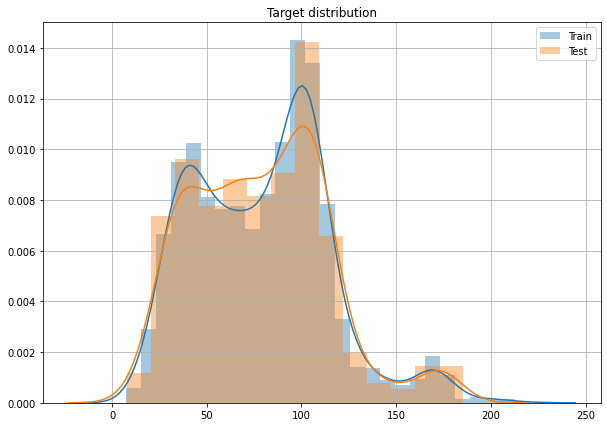

In [16]:
import seaborn as sns
plt.figure(figsize=(10, 7))
plt.title("Target distribution")
sns.distplot(y_train, label="Train")
sns.distplot(y_test, label="Test")
plt.legend()
plt.grid()

##### And the last, but not least piece that we need over here 
### Hyperparemeter optimizer

In [17]:
from catboost import Pool, CatBoostRegressor

class HPOptimization:
    def __init__(self, X_train, y_train, 
                       X_test, y_test, 
                       space, 
                       objective_instance,
                       rating_instance,
                       cat_features = [],
                       max_evals=100):
        self._space = space
        self._max_evals = max_evals
        self._eval_obj = objective_instance
        self._rating_obj = rating_instance
        self._algo = CatBoostRegressor
        self._train_pool = Pool(X_train, y_train, cat_features=cat_features)
        self._test_pool = Pool(X_test, y_test, cat_features=cat_features)
        self._y_true = y_test
        self.eval_rounds = []
        
    def calc_objective(self, y_pred, y_test):
        error_sum, weight_sum = self._eval_obj.evaluate([y_pred], y_test)
        return self._eval_obj.get_final_error(error_sum, weight_sum)
    
    def calc_rating(self, y_pred, y_test):
        error_sum, weight_sum = self._rating_obj.evaluate([y_pred], y_test)
        return self._rating_obj.get_final_error(error_sum, weight_sum)
    
    def _update_parameters(self, params):
        meta_params = {}

        if params['loss_function'] == "PiecewiseMSE" or params['loss_function'] == "BiasedPiecewiseMSE":
            params_to_remove = []
            intervals = {}
            for param, value in params.items():
                if param.startswith("coef_") or param.startswith("bias_"):
                    name = param.split("_")[0]
                    meta_params[param] = value
                    params_to_remove.append(param)
                    param=param.replace("{}_".format(name), "")
                    interval = tuple([float(p) for p in param.split(';')])
                    if interval not in intervals:
                        intervals[interval] = {}
                    intervals[interval][name] = value
                    
            for p in params_to_remove:
                del params[p]
            
            if params['loss_function'] == "PiecewiseMSE":
                params['loss_function'] = PiecewiseMSE(intervals)
            elif params['loss_function'] == "BiasedPiecewiseMSE":
              params['loss_function'] = BiasedPiecewiseMSE(intervals)
        elif params['loss_function'] == "Quantile":
            params['loss_function'] = "Quantile" + ":alpha={}".format(round(params['alpha'] / 100, 2))
            del params['alpha']
        return params, meta_params
    
    def _objective(self, params):
        params, meta_params = self._update_parameters(params)

        print("Running {}".format(str(params)))
        
        model = self._algo(**params)
        model.fit(self._train_pool, eval_set=self._test_pool)
        y_pred = model.predict(self._test_pool)
        obj = self.calc_objective(y_pred, self._y_true)
        rating = self.calc_rating(y_pred, self._y_true)
        self.eval_rounds.append({'params': params,
                                 'obj': obj,
                                 'meta_params': meta_params,
                                 'y_test': self._y_true,
                                 'rating': rating,
                                 'y_pred': y_pred})
        print('---------------')
        print("Objective = {:.2f}| Rating = {:.2f}".format(obj, rating))
        print('=================================\n\n')
        return obj
    
    def optimize(self):
        trials = Trials()
        best = fmin(self._objective,
                    self._space,
                    algo=tpe.suggest,
                    trials=trials,
                    max_evals=self._max_evals,
                    return_argmin=True)
        best = space_eval(self._space, best)
        best, meta_params = self._update_parameters(best)
        min_idx = np.argmin([self.eval_rounds[i]['obj'] for i in range(len(self.eval_rounds))])
        best_rating = abs(self.eval_rounds[min_idx]['rating'])
        print("The best score {:.2f}({:.2f}) by the best parameters {}".format(trials.best_trial['result']['loss'],
                                                                               best_rating,
                                                                               str(best)))
        return best, trials.best_trial['result']['loss'], best_rating, meta_params

### and the last but not least, pretty visualization to make the reader's experience joyful :) 


In [18]:
from matplotlib.animation import FuncAnimation


class OptimizationVisualizer:
    
    def __init__(self, hpo):
        fig, axis = plt.subplots(ncols=2, figsize=(22, 8))
        self.fig = fig
        self._op_ax = axis[0]
        self._ob_ax = axis[1]
        self._hpo = hpo
        self._initialize_plots()
        
    def _initialize_plots(self):
        objs = [-er['rating'] for er in self._hpo.eval_rounds]
        self._objective_plot,  = self._ob_ax.plot([0], [objs[0]], 'b-', linewidth=1)
        self._minimal_value_plot,  = self._ob_ax.plot([0], [objs[0]], 'ro')
        self._text = self._ob_ax.text(0.04, 1.1*max(objs)-0.1, 'Max Expected Rating = {:.2f}'.format(objs[0]), 
                                      bbox=dict(boxstyle="round",
                                                   ec=(1., 0.5, 0.5),
                                                   fc=(1., 0.8, 0.8),
                                               ),
                                      fontsize=14)

        self._ob_ax.grid()
        self._ob_ax.set_xlim(0, len(objs) - 0.5)
        self._ob_ax.set_ylabel("Expected average rating")
        self._ob_ax.set_xlabel("HPO Iteration #")
        self._ob_ax.set_ylim(min(objs) * 0.9, max(objs) * 1.1)

        x, y = plot_loss(self._hpo.eval_rounds[0]['params']['loss_function'])
        self._loss_plot,  = self._op_ax.plot(x, y, 'b-', linewidth=1)
        self._op_ax.set_title("Loss function")
        self._op_ax.set_xlabel("y_true - y_pred: y_true=0")
        self._op_ax.grid()

    def plot_optimization(self, i):
        try:
          objs = [-er['rating'] for er in self._hpo.eval_rounds[:i+1]]
          self._objective_plot.set_xdata(np.arange(len(objs)))
          self._objective_plot.set_ydata(objs)
          self._text.set_text('Max Expected Rating = {:.2f}'.format(max(objs)))

          self._minimal_value_plot.set_xdata([np.argmax(objs)])
          self._minimal_value_plot.set_ydata([max(objs)])
          self._ob_ax.set_title("HPO: Iteration {}".format(i))

          x, y = plot_loss(self._hpo.eval_rounds[i]['params']['loss_function'])
          self._loss_plot.set_xdata(x)
          self._loss_plot.set_ydata(y)
        except Exception as e:
          print(str(e))
        return self._minimal_value_plot, self._objective_plot

In [19]:
from IPython.display import HTML
import matplotlib.animation as animation
def generate_animation(hpo, name, interval=250):
    ov = OptimizationVisualizer(hpo)
    
    anim = FuncAnimation(ov.fig, 
                         ov.plot_optimization, 
                         frames=np.arange(0, len(hpo.eval_rounds)), 
                         interval=interval)
    anim.save("gif/{}.gif".format(name), writer=animation.PillowWriter(fps=interval))

    HTML('<img src="gif/{}.gif">'.format(name))

# So, we are all set to gooooo

what is our business objective? In our toy case, we use the the average rating per interval

In [20]:
config = {(-int(1e10), -10): {"coef": 4.1},
          (-10, -3): {"coef": 4.9},
          (-3, 0): {"coef": 4.9},
          (0, 5): {"coef": 4.6},
          (5, 11): {"coef": 4.1},
          (11, 18): {"coef": 2.9},
          (18, int(1e10)): {"coef": 1.7}}

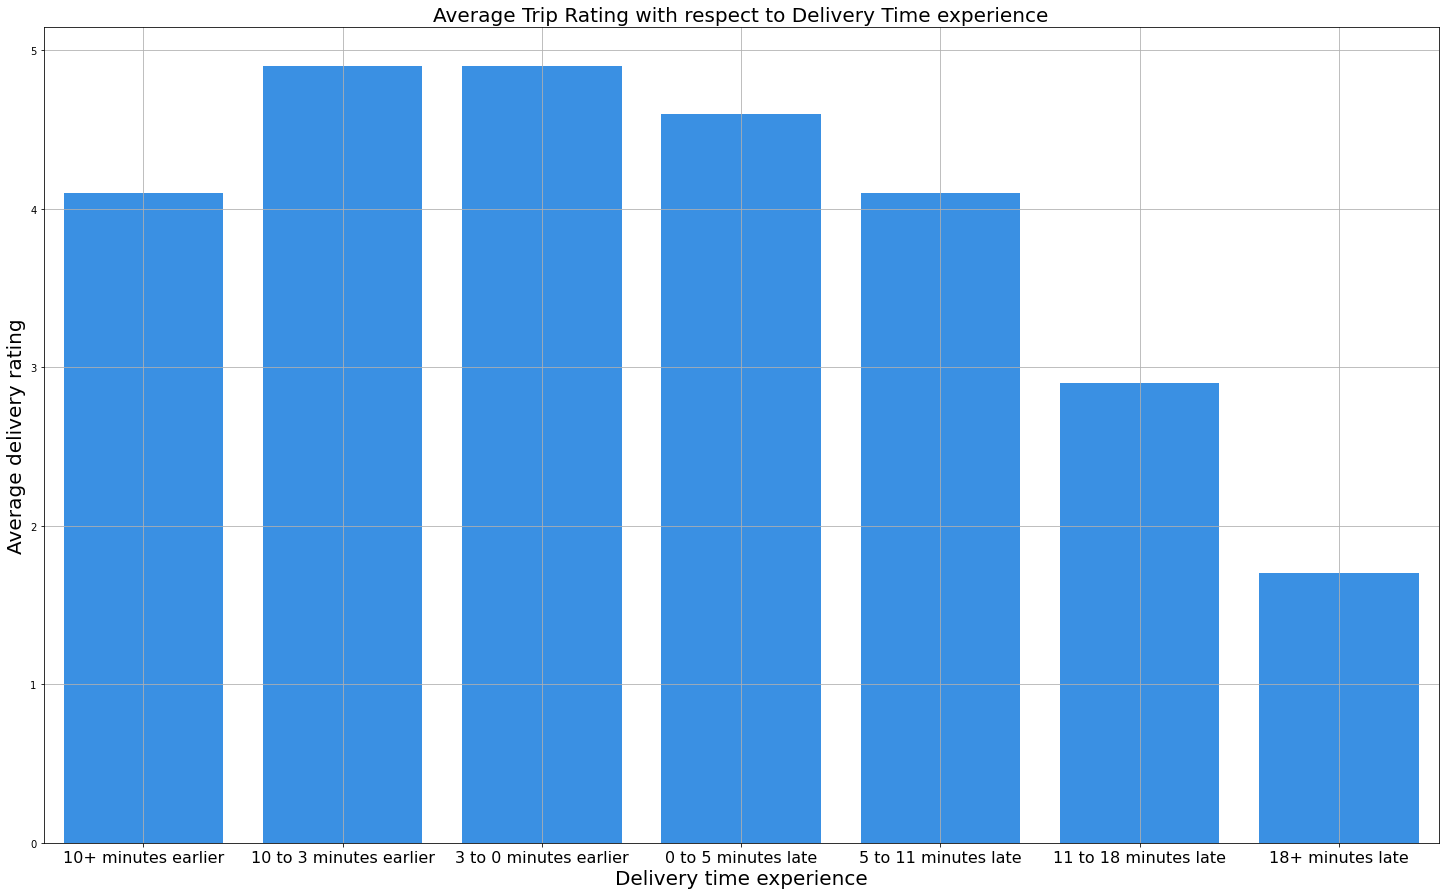

In [21]:
import seaborn as sns


def plot_config(config):
    texts = []
    ratings = []
    for low, up in config.keys():
        r = config[(low, up)]["coef"]
        label = ""
        if low < -1e5:
            label = "{}+ minutes earlier".format(abs(up))
        if up < 1e-5 and low < 1e-5 and low > -1e5:
            label = "{} to {} minutes earlier".format(abs(low), abs(up))
        if up > -1e-5 and low > -1e-5:
            label = "{} to {} minutes late".format(abs(low), abs(up))
        if up > 1e5:
            label = "{}+ minutes late".format(abs(low))
        texts.append(label) 
        ratings.append(r)
        
    plt.figure(figsize=(25, 15))
    sns.barplot(x=texts,
                y=ratings,
                color='dodgerblue')
    plt.xlabel("Delivery time experience", fontsize=20)
    plt.ylabel("Average delivery rating", fontsize=20)
    plt.title("Average Trip Rating with respect to Delivery Time experience", fontsize=20)
    plt.xticks(fontsize=16)
    plt.grid()
    plt.show()

plot_config(config)

In [22]:
rating_objective = RatingObjective(config)
rmse_objective = RMSEObjective()
RESULTS = []

in order to tune hyperparameters of our model, we need to define the space

In [23]:
from hyperopt import fmin, tpe, STATUS_OK, Trials, space_eval, hp
from copy import copy

hpo_space = {
    'random_seed': 42,
    'max_depth': hp.quniform('max_depth', 4, 12, 1),
    'learning_rate': hp.choice('learning_rate', [0.002, 0.005, 0.01, 0.04, 0.1]),
    'random_strength': hp.uniform('random_strength', 0.0, 100),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'one_hot_max_size': hp.choice('one_hot_max_size', [0, 25, 50, 100, 200]),
    'use_best_model': True,
    'od_wait': 300,
    'verbose': 0,
    'task_type': 'CPU',
    'cat_features': data_loader.get_cat_features_idx(),
    'iterations': 700}

# Optimize Hyper-Params with RMSE using RMSE as objective

In [24]:
hpo_space_rmse_rmse = copy(hpo_space)
hpo_space_rmse_rmse['loss_function'] = 'RMSE'
hpo_space_rmse_rmse['eval_metric'] = 'RMSE'

hpo_rmse_rmse = HPOptimization(X_train, y_train, X_test, y_test, 
                               space=hpo_space_rmse_rmse, 
                               objective_instance=rmse_objective,
                               rating_instance=rating_objective,
                               cat_features=data_loader.get_cat_features_idx(),
                               max_evals=MAX_EVALS)
best_params, best_loss, best_rating, meta = hpo_rmse_rmse.optimize()
RESULTS.append(['RMSE Loss with RMSE objective', best_rating])

Running {'bagging_temperature': 0.9621853767056607, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': 'RMSE', 'iterations': 700, 'l2_leaf_reg': 4.5967534716598175, 'learning_rate': 0.002, 'loss_function': 'RMSE', 'max_depth': 7.0, 'od_wait': 300, 'one_hot_max_size': 100, 'random_seed': 42, 'random_strength': 42.613143457216694, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = 35.19| Rating = -3.30


Running {'bagging_temperature': 0.8483265484382667, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': 'RMSE', 'iterations': 700, 'l2_leaf_reg': 5.955580993809065, 'learning_rate': 0.01, 'loss_function': 'RMSE', 'max_depth': 7.0, 'od_wait': 300, 'one_hot_max_size': 200, 'random_seed': 42, 'random_strength': 80.63850620924018, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = 34.84| Rating = -3.29


Running {'bagging_temperature': 0.9598084549176789, 'cat_features': (0, 5, 13, 17, 22, 23

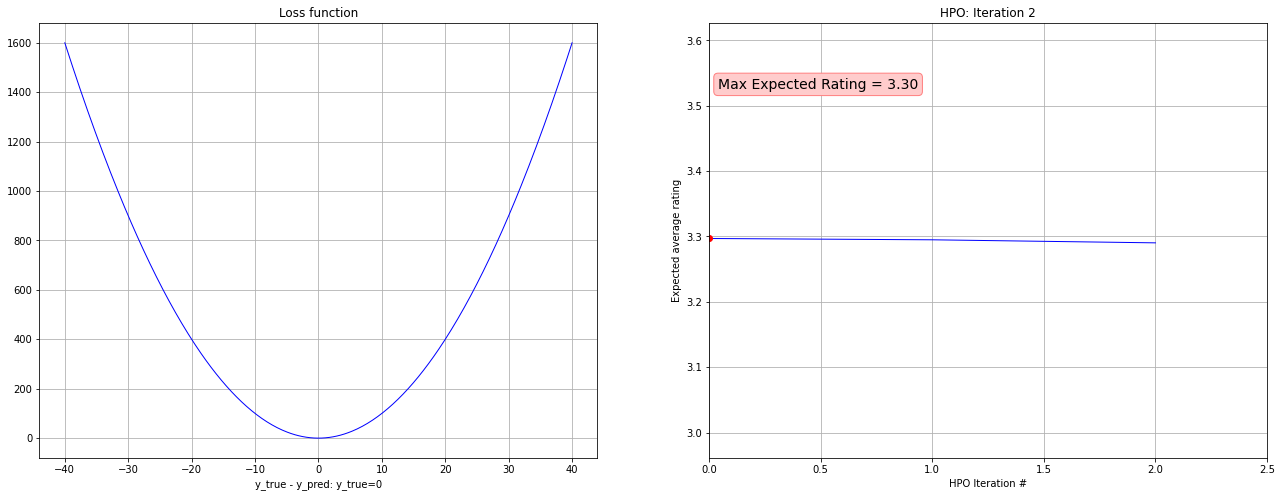

In [25]:
generate_animation(hpo_rmse_rmse, "rmse_rmse")

# RMSE with expected Rating objective

In [26]:
from hyperopt import fmin, tpe, STATUS_OK, Trials, space_eval, hp

hpo_space_rmse_rating = copy(hpo_space_rmse_rmse)
hpo_space_rmse_rating['eval_metric'] = rating_objective


hpo_rmse_rating = HPOptimization(X_train, y_train, X_test, y_test, 
                                 space=hpo_space_rmse_rating, 
                                 objective_instance=rating_objective,
                                 rating_instance=rating_objective,
                                 max_evals=MAX_EVALS,
                                 cat_features=data_loader.get_cat_features_idx())
best_params, best_loss, best_rating, meta = hpo_rmse_rating.optimize()
RESULTS.append(['RMSE Loss with Rating objective', best_rating])

Running {'bagging_temperature': 0.15029036419270803, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 6.624797131638131, 'learning_rate': 0.04, 'loss_function': 'RMSE', 'max_depth': 11.0, 'od_wait': 300, 'one_hot_max_size': 100, 'random_seed': 42, 'random_strength': 6.074429083290833, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = -3.32| Rating = -3.32


Running {'bagging_temperature': 0.6297780860850479, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 1.4045143380611307, 'learning_rate'

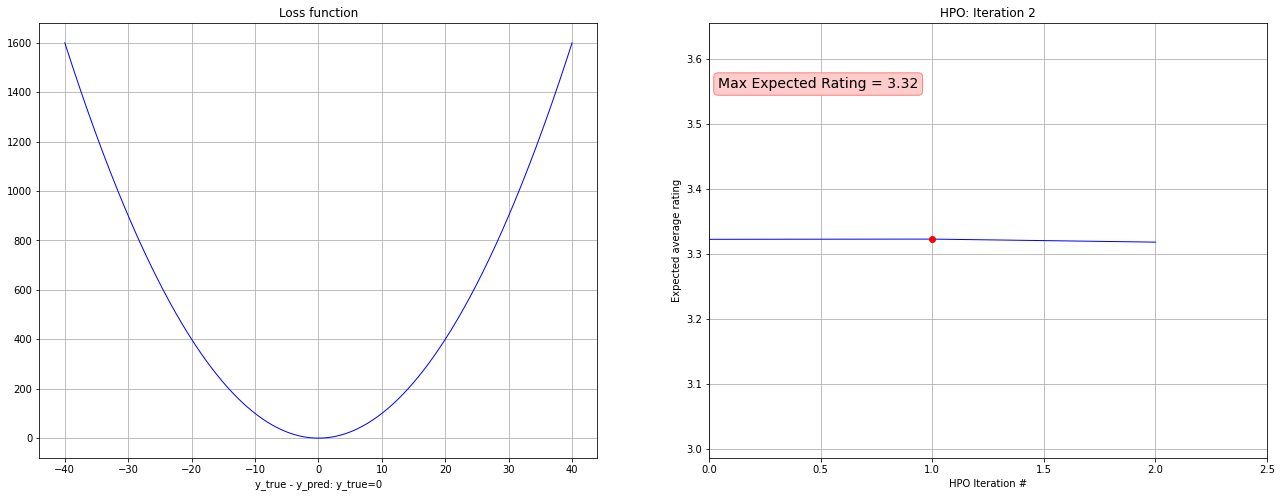

In [27]:
generate_animation(hpo_rmse_rating, "rmse_rating", interval=150)

# Bonus: Quantile regression

In [28]:
hpo_space_quantile_rating = copy(hpo_space)
hpo_space_quantile_rating['loss_function'] = 'Quantile'
hpo_space_quantile_rating['alpha'] = hp.uniform('alpha', 5, 95)
hpo_space_quantile_rating['eval_metric'] = rating_objective

In [29]:
hpo_quantile_rating = HPOptimization(X_train, y_train, X_test, y_test, 
                                     space=hpo_space_quantile_rating, 
                                     objective_instance=rating_objective,
                                     rating_instance=rating_objective,
                                     max_evals=MAX_EVALS,
                                     cat_features=data_loader.get_cat_features_idx())
best_params, best_loss, best_rating, meta_params = hpo_quantile_rating.optimize()
RESULTS.append(['Quantile Loss with Rating objective', best_rating])

Running {'bagging_temperature': 0.259012613064455, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 2.018975386882685, 'learning_rate': 0.1, 'loss_function': 'Quantile:alpha=0.5', 'max_depth': 6.0, 'od_wait': 300, 'one_hot_max_size': 200, 'random_seed': 42, 'random_strength': 25.730097553589037, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = -3.36| Rating = -3.36


Running {'bagging_temperature': 0.8219761702180339, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 3.4975153048884295, 'lea

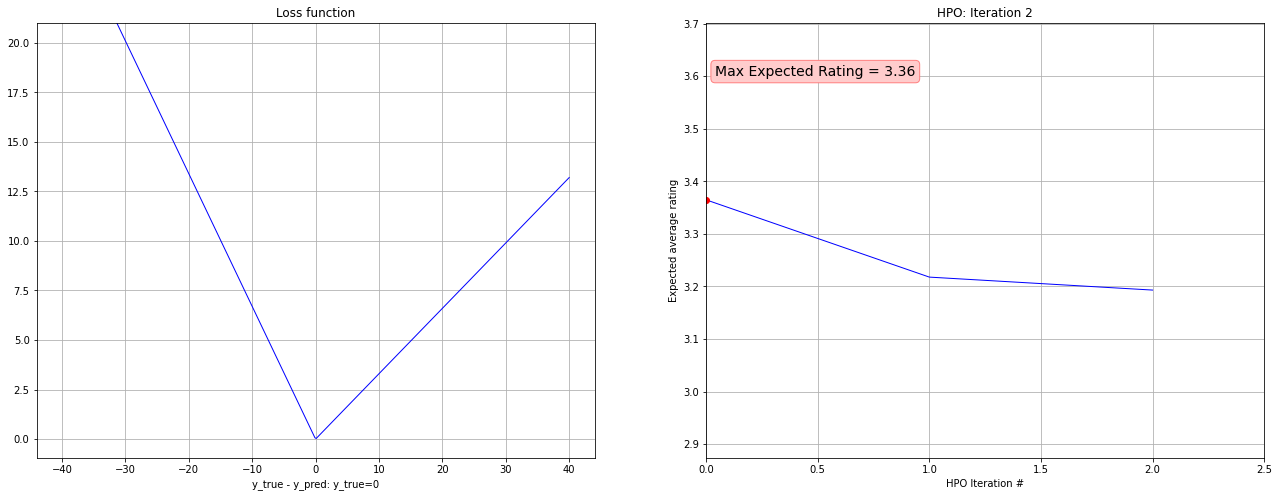

In [30]:
generate_animation(hpo_quantile_rating, "quantile_rating")

# Piecewise MSE with static coefs

Text(0, 0.5, 'loss')

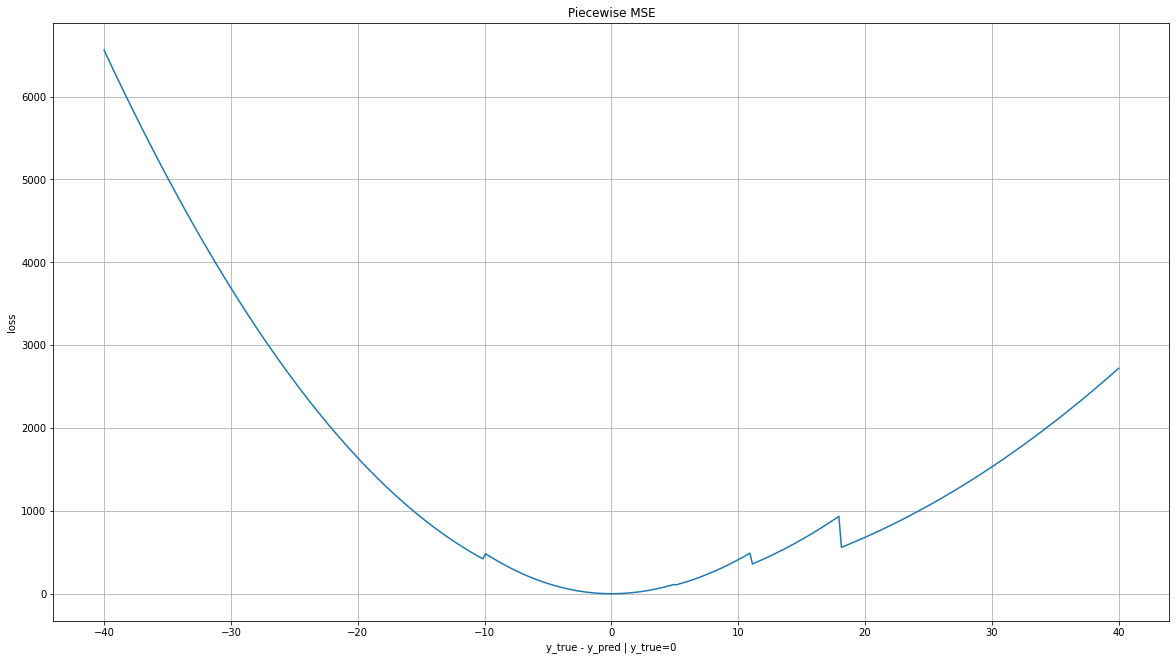

In [31]:
pwmse = PiecewiseMSE(config, (-25, 25))
x, y = plot_loss(pwmse)
plt.figure(figsize=(20, 11))
plt.title("Piecewise MSE")
plt.plot(x, y)
plt.grid()
plt.xlabel("y_true - y_pred | y_true=0")
plt.ylabel("loss")

In [32]:
hpo_space_piecewisemse_rating_standart = copy(hpo_space)

hpo_space_piecewisemse_rating_standart['loss_function'] = pwmse
hpo_space_piecewisemse_rating_standart['eval_metric'] = rating_objective

In [34]:
hpo_quantile_piecewise_standart = HPOptimization(X_train, y_train, X_test, y_test, 
                                     space=hpo_space_piecewisemse_rating_standart, 
                                     objective_instance=rating_objective,
                                     rating_instance=rating_objective,
                                     max_evals=MAX_EVALS,
                                     cat_features=data_loader.get_cat_features_idx())
best_params, best_loss, best_rating, meta_params = hpo_quantile_piecewise_standart.optimize()
RESULTS.append(['Piecewise Loss with Rating Obj and Fixed Coefs', best_rating])

Running {'bagging_temperature': 0.7814989855740623, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 8.525315029614974, 'learning_rate': 0.1, 'loss_function': PiecewiseMSE:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'max_depth': 9.0, 'od_wait': 300, 'one_hot_max_size': 25, 'random_seed': 42, 'random_strength': 93.15411504409198, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = -3.25| Rating = -3.25


Running {'bagging_temperature': 0.21853949060961753, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> c

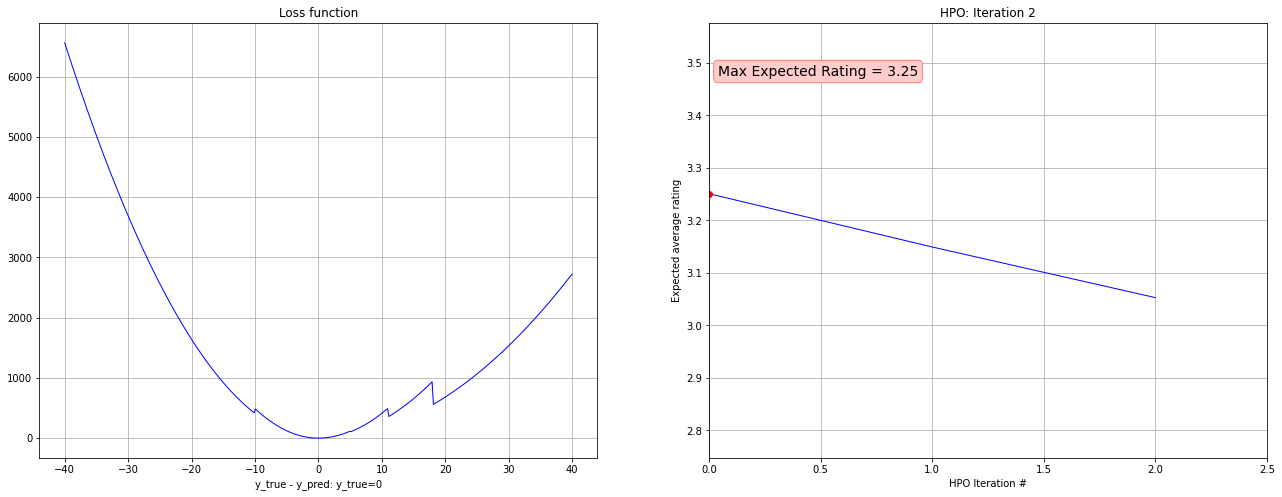

In [35]:
generate_animation(hpo_quantile_piecewise_standart, "piecewise_rating", interval=125)

# Piecewise MSE with Rating objective

In [36]:
def turn_config_into_hp(config, prefix="coef"):
    interval_names = []
    for low, up in config.keys():
        interval_names.append("{}_{};{}".format(prefix, low, up))
        
    return interval_names 

In [37]:
hpo_space_piecewisemse_rating = copy(hpo_space)

hpo_space_piecewisemse_rating['loss_function'] = 'PiecewiseMSE'
hpo_space_piecewisemse_rating['eval_metric'] = rating_objective

for interval_name in turn_config_into_hp(config):
    hpo_space_piecewisemse_rating[interval_name] = hp.uniform(interval_name, 0, 20)
hpo_space_piecewisemse_rating

{'bagging_temperature': <hyperopt.pyll.base.Apply at 0x7f129c2d6780>,
 'cat_features': [0, 5, 13, 17, 22, 23, 25, 27, 29],
 'coef_-10000000000;-10': <hyperopt.pyll.base.Apply at 0x7f129a70c2e8>,
 'coef_-10;-3': <hyperopt.pyll.base.Apply at 0x7f129a70c780>,
 'coef_-3;0': <hyperopt.pyll.base.Apply at 0x7f129a70c710>,
 'coef_0;5': <hyperopt.pyll.base.Apply at 0x7f129a770240>,
 'coef_11;18': <hyperopt.pyll.base.Apply at 0x7f129a6feb38>,
 'coef_18;10000000000': <hyperopt.pyll.base.Apply at 0x7f129a6fe940>,
 'coef_5;11': <hyperopt.pyll.base.Apply at 0x7f129a7702b0>,
 'eval_metric': RatingObjective:
 (-10000000000, -10) -> coef=4.1
 (-10, -3) -> coef=4.9
 (-3, 0) -> coef=4.9
 (0, 5) -> coef=4.6
 (5, 11) -> coef=4.1
 (11, 18) -> coef=2.9
 (18, 10000000000) -> coef=1.7,
 'iterations': 700,
 'l2_leaf_reg': <hyperopt.pyll.base.Apply at 0x7f129c2d6630>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x7f129c2d6278>,
 'loss_function': 'PiecewiseMSE',
 'max_depth': <hyperopt.pyll.base.Apply at 0x7f1

In [38]:
hpo_piecewise_rating = HPOptimization(X_train, y_train, X_test, y_test, 
                                      space=hpo_space_piecewisemse_rating, 
                                      objective_instance=rating_objective,
                                      rating_instance=rating_objective,
                                      max_evals=2*MAX_EVALS,
                                      cat_features=data_loader.get_cat_features_idx())
best_params, best_loss, best_rating, meta_params = hpo_piecewise_rating.optimize()
RESULTS.append(['Piecewise Loss with Rating objective', best_rating])

Running {'bagging_temperature': 0.6585927135399006, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 4.412221688994837, 'learning_rate': 0.005, 'loss_function': PiecewiseMSE:
(-10000000000.0, -10.0) -> coef=18.27121516874701
(-10.0, -3.0) -> coef=9.981590065060601
(-3.0, 0.0) -> coef=17.03082924174025
(0.0, 5.0) -> coef=9.103225447276525
(5.0, 11.0) -> coef=17.47420274666277
(11.0, 18.0) -> coef=2.195657324887108
(18.0, 10000000000.0) -> coef=11.036222938202961, 'max_depth': 9.0, 'od_wait': 300, 'one_hot_max_size': 25, 'random_seed': 42, 'random_strength': 96.89878334184418, 'task_type': 'CPU', 'use_best_model': True, 'verbose': 0}
---------------
Objective = -3.12| Rating = -3.12


Running {'bagging_temperature': 0.20572411363099752, 'cat_features': (0, 5

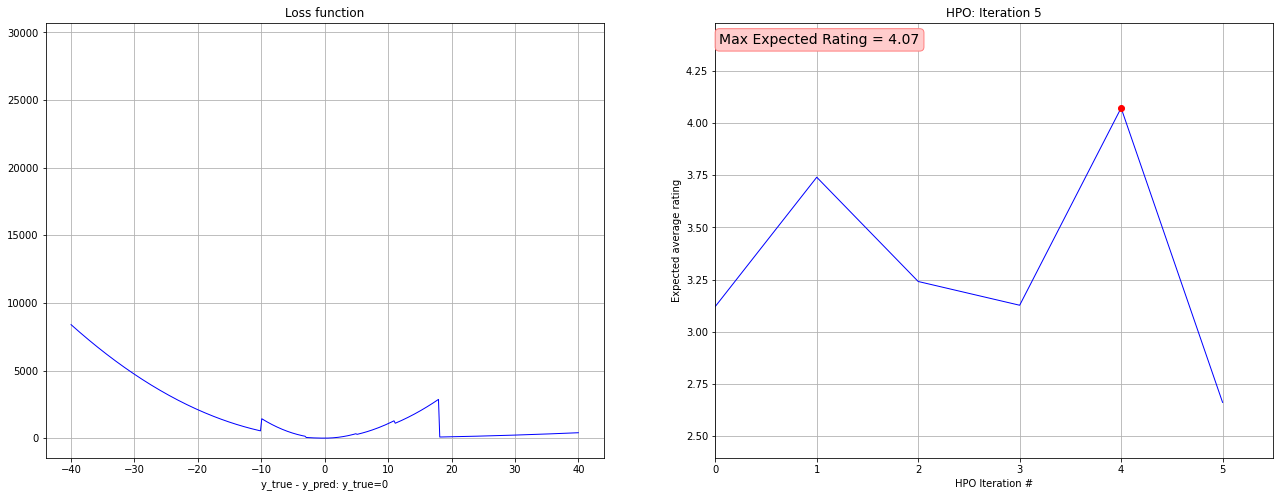

In [39]:
generate_animation(hpo_piecewise_rating, "piecewise_rating", interval=125)

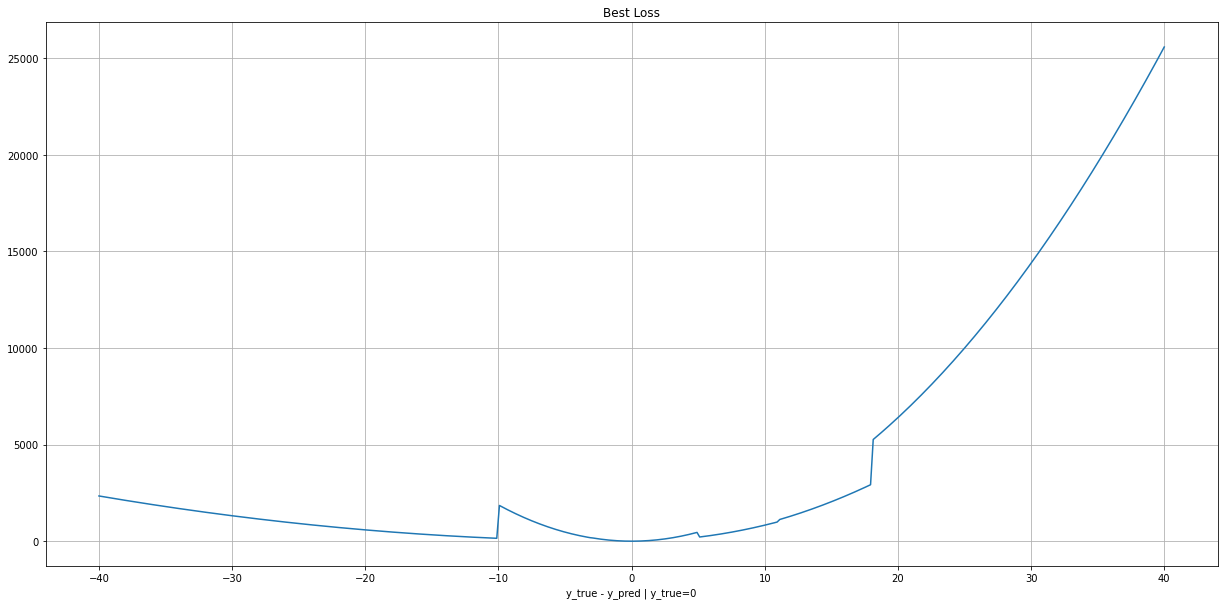

In [40]:
x, y = plot_loss(best_params['loss_function'])
_, ax = plt.subplots(figsize=(21, 10))
ax.set_title("Best Loss")
ax.plot(x, y)
ax.set_xlabel("y_true - y_pred | y_true=0")
ax.grid()

# BiasedPiecewiseMSE

In [41]:
hpo_space_biased_piecewisemse_rating = copy(hpo_space)

hpo_space_biased_piecewisemse_rating['loss_function'] = 'BiasedPiecewiseMSE'
hpo_space_biased_piecewisemse_rating['eval_metric'] = rating_objective

for interval_name in turn_config_into_hp(config, prefix="coef"):
    hpo_space_biased_piecewisemse_rating[interval_name] = hp.uniform(interval_name, 0, 20)

for interval_name in turn_config_into_hp(config, prefix="bias"):
    hpo_space_biased_piecewisemse_rating[interval_name] = hp.uniform(interval_name, -30, 30)
hpo_space_biased_piecewisemse_rating

{'bagging_temperature': <hyperopt.pyll.base.Apply at 0x7f129c2d6780>,
 'bias_-10000000000;-10': <hyperopt.pyll.base.Apply at 0x7f129a8f65c0>,
 'bias_-10;-3': <hyperopt.pyll.base.Apply at 0x7f129a8f6668>,
 'bias_-3;0': <hyperopt.pyll.base.Apply at 0x7f129a8f6630>,
 'bias_0;5': <hyperopt.pyll.base.Apply at 0x7f129a8f6a58>,
 'bias_11;18': <hyperopt.pyll.base.Apply at 0x7f129a8f6d68>,
 'bias_18;10000000000': <hyperopt.pyll.base.Apply at 0x7f129a8f6128>,
 'bias_5;11': <hyperopt.pyll.base.Apply at 0x7f129a8f6828>,
 'cat_features': [0, 5, 13, 17, 22, 23, 25, 27, 29],
 'coef_-10000000000;-10': <hyperopt.pyll.base.Apply at 0x7f129a90c6a0>,
 'coef_-10;-3': <hyperopt.pyll.base.Apply at 0x7f129a875588>,
 'coef_-3;0': <hyperopt.pyll.base.Apply at 0x7f129a6fef28>,
 'coef_0;5': <hyperopt.pyll.base.Apply at 0x7f129a914278>,
 'coef_11;18': <hyperopt.pyll.base.Apply at 0x7f129a8366d8>,
 'coef_18;10000000000': <hyperopt.pyll.base.Apply at 0x7f129a605d68>,
 'coef_5;11': <hyperopt.pyll.base.Apply at 0x7f12

In [42]:
hpo_bias_piecewise_rating = HPOptimization(X_train, y_train, X_test, y_test, 
                                           space=hpo_space_biased_piecewisemse_rating, 
                                           objective_instance=rating_objective,
                                           rating_instance=rating_objective,
                                           max_evals=3*MAX_EVALS,
                                           cat_features=data_loader.get_cat_features_idx())
best_params, best_loss, best_rating, meta_params = hpo_bias_piecewise_rating.optimize()
RESULTS.append(['Biased Piecewise Loss with Rating objective', best_rating])

Running {'bagging_temperature': 0.5757658471532526, 'cat_features': (0, 5, 13, 17, 22, 23, 25, 27, 29), 'eval_metric': RatingObjective:
(-10000000000, -10) -> coef=4.1
(-10, -3) -> coef=4.9
(-3, 0) -> coef=4.9
(0, 5) -> coef=4.6
(5, 11) -> coef=4.1
(11, 18) -> coef=2.9
(18, 10000000000) -> coef=1.7, 'iterations': 700, 'l2_leaf_reg': 1.4748340092321341, 'learning_rate': 0.01, 'loss_function': BiasedPiecewiseMSE:
(-10000000000.0, -10.0) -> bias=-14.621923857319082|coef=18.20947433465097
(-10.0, -3.0) -> bias=10.150292761268261|coef=10.963289578267077
(-3.0, 0.0) -> bias=-24.30093238259079|coef=9.461252889500017
(0.0, 5.0) -> bias=18.13549784101705|coef=16.360894831198923
(5.0, 11.0) -> bias=-0.1272509148653036|coef=15.92511012543393
(11.0, 18.0) -> bias=-5.984362326938818|coef=14.213269480292059
(18.0, 10000000000.0) -> bias=26.142742612361268|coef=17.851601644168305, 'max_depth': 10.0, 'od_wait': 300, 'one_hot_max_size': 50, 'random_seed': 42, 'random_strength': 7.629288001525147, 'task

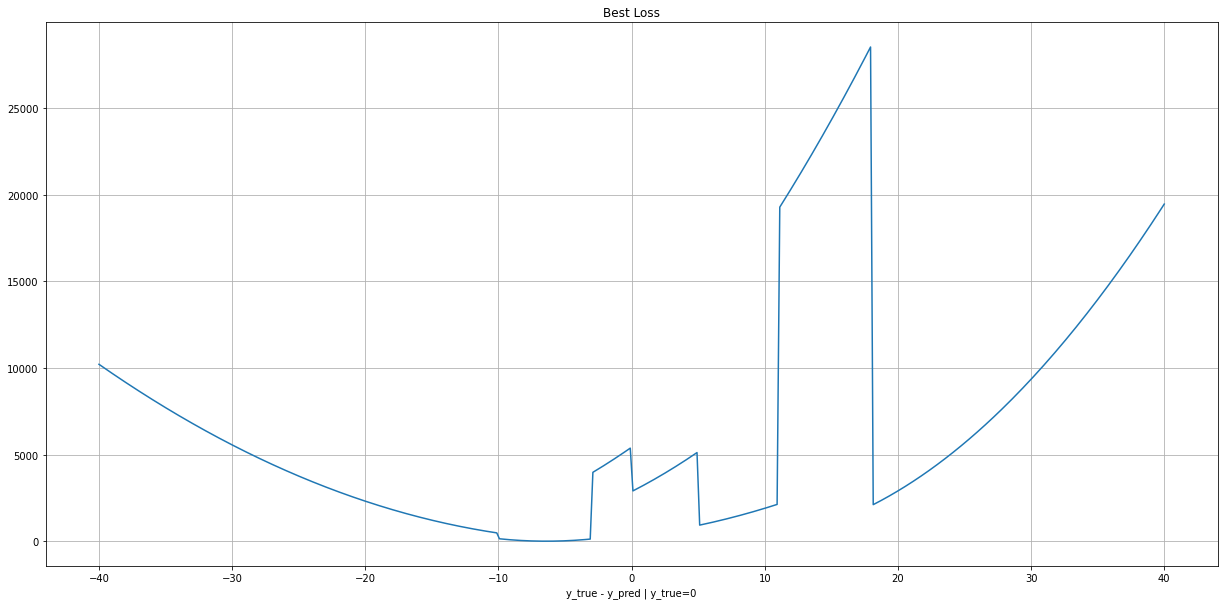

In [43]:
x, y = plot_loss(best_params['loss_function'])
_, ax = plt.subplots(figsize=(21, 10))
ax.set_title("Best Loss")
ax.plot(x, y)
ax.set_xlabel("y_true - y_pred | y_true=0")
ax.grid()

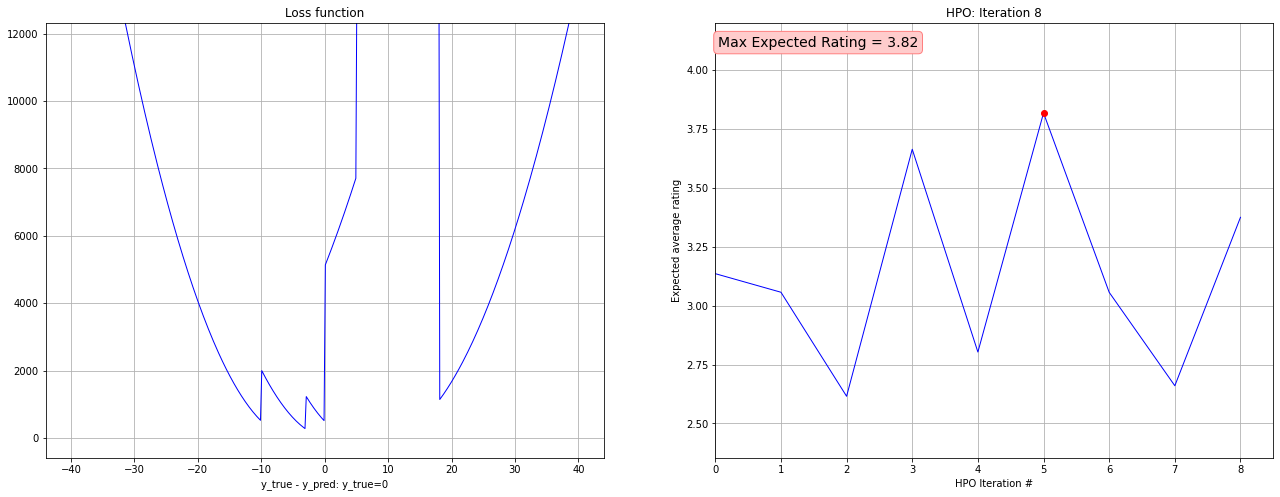

In [44]:
generate_animation(hpo_bias_piecewise_rating, "bias_piecewise_rating")

# Conclution

In [45]:
df_rating = pd.DataFrame(RESULTS, columns=['Variant', 'Expected Rating']).round(2)

In [46]:
df_rating

,Variant,Expected Rating
0,RMSE Loss with RMSE objective,3.29
1,RMSE Loss with Rating objective,3.32
2,Quantile Loss with Rating objective,3.36
3,Piecewise Loss with Rating Obj and Fixed Coefs,3.25
4,Piecewise Loss with Rating objective,4.07
5,Biased Piecewise Loss with Rating objective,3.82
